In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# Loading the preprocessed file
df = pd.read_csv('pre_processed.csv')


In [37]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [38]:
y = df['loan_status'] # target variable

y.value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1962
Does not meet the credit policy. Status:Charged Off      758
Name: loan_status, dtype: int64

In [39]:
# Label encoding the target variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y= le.transform(y)
y

array([3, 0, 3, ..., 2, 2, 2])

In [40]:
# All these columns are based on future transactions(We only want data that contains info before charging off a loan)

df.drop(['total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
        'total_rec_late_fee','recoveries'],inplace=True,axis=1)


In [41]:
# Checking for multi-collinearity between features

df2 = df.drop('loan_status',axis=1)
 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
a = pd.DataFrame({'vif': vif[:]}, index=df2.columns)
a[a['vif']>15]

,vif
loan_amnt,94.229123
funded_amnt,288.339859
funded_amnt_inv,40.718240
term,43.842363
int_rate,115.846222
installment,145.444515
grade,63.218912
sub_grade,106.076450
issue_d_year,122.182965
last_pymnt_d_year,44.205610


In [42]:
# Dropping columns that are highly correlated
df2.drop(['grade','issue_d_year','funded_amnt','term','installment','loan_amnt','int_rate','last_pymnt_d_year'],axis=1,inplace=True) # No need to remove subgrade 

In [43]:
df = df2

In [44]:
# Final shape of the dataframe
df.shape

(42506, 38)

## Model Building

In [45]:
# Dividing the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df,y,test_size = 0.20 ,random_state = 2, stratify =y)

x_train.shape,y_train.shape,x_test.shape,y_test.shape

((34004, 38), (34004,), (8502, 38), (8502,))

In [46]:
# Base model
from sklearn.tree import DecisionTreeClassifier
giniDecisionTree = DecisionTreeClassifier(criterion='gini',random_state = 100,max_depth=3,class_weight='balanced', min_samples_leaf=5)

giniDecisionTree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=5,
                       random_state=100)

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

giniPred = giniDecisionTree.predict(x_test)

print('Accuracy Score: ',accuracy_score(y_test, giniPred))

Accuracy Score:  0.6706657257115972


In [48]:
##  Checking classification_report

print('Classification Report')
print(classification_report(y_test, giniPred))

Classification Report
              precision    recall  f1-score   support

           0       0.30      0.91      0.46      1134
           1       0.43      0.68      0.53       152
           2       0.53      0.51      0.52       392
           3       0.97      0.64      0.77      6824

    accuracy                           0.67      8502
   macro avg       0.56      0.69      0.57      8502
weighted avg       0.85      0.67      0.71      8502



In [49]:
# Tuning the parameters to find the best decision tree model.
model = DecisionTreeClassifier(criterion='gini',random_state = 100,class_weight='balanced')

param_dist = {'max_depth': [2, 3, 4,5,6,7,8,9], 'min_samples_leaf' : [2,3,4,5,6,7,8]}

from sklearn.model_selection import GridSearchCV
cv_dt = GridSearchCV(model, cv = 3,param_grid=param_dist, n_jobs = -1)

cv_dt.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_dt.best_params_)


Best Parameters using grid search: 
 {'max_depth': 9, 'min_samples_leaf': 4}


In [50]:
# Training with the best parameters

model = DecisionTreeClassifier(criterion='gini',random_state = 100,max_depth=9,class_weight='balanced', min_samples_leaf=2)
model.fit(x_train, y_train)
giniPred = model.predict(x_test)

print('Accuracy Score: ',accuracy_score(y_test, giniPred))

Accuracy Score:  0.7858151023288638


In [51]:
##  Checking classification_report
print('Classification Report')
print(classification_report(y_test, giniPred))

Classification Report
              precision    recall  f1-score   support

           0       0.42      0.80      0.55      1134
           1       0.43      0.75      0.55       152
           2       0.57      0.71      0.63       392
           3       0.96      0.79      0.87      6824

    accuracy                           0.79      8502
   macro avg       0.60      0.76      0.65      8502
weighted avg       0.86      0.79      0.81      8502



DT: 0.336402 (0.013364)
RandomForest: 0.273998 (0.015075)
Bagged: 0.103282 (0.000507)
AdaBoost: 0.129514 (0.003323)
GradientBoost: 0.107105 (0.000265)


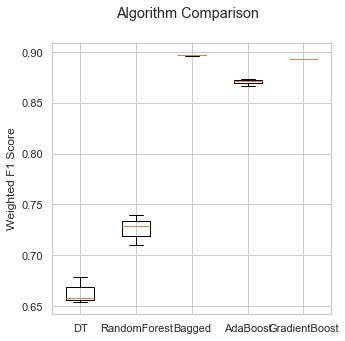

In [52]:
# Trying few more ML algos to find the best fit model
# Importing libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import model_selection
sns.set(rc={'figure.figsize':(3,3)})
sns.set_style('whitegrid')


import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)


DT=DecisionTreeClassifier(criterion='gini',random_state = 100,max_depth=5,class_weight='balanced', min_samples_leaf=5)
RF=RandomForestClassifier(criterion='gini',random_state = 100,max_depth=5,class_weight='balanced', min_samples_leaf=5,n_estimators=20)
Bagged=BaggingClassifier(n_estimators=50)
AdaBoost=AdaBoostClassifier(n_estimators=50)
GBoost=GradientBoostingClassifier(n_estimators=50)
models = []

models.append(('DT',DT))
models.append(('RandomForest',RF))
models.append(('Bagged',Bagged))
models.append(('AdaBoost',AdaBoost))
#models.append(('AdaBoostRF',AB_RF))
models.append(('GradientBoost',GBoost))

# evaluating each model in turn using KFold CV with 3 splits
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(shuffle=True,n_splits=3,random_state=0)
	cv_results = model_selection.cross_val_score(model, x_train, y_train,cv=kfold, scoring='f1_micro')
	results.append(cv_results)
	names.append(name)
	print("%s: %f (%f)" % (name, 1-np.mean(cv_results),np.std(cv_results,ddof=1)))
   # boxplot algorithm comparison
fig = plt.figure()
sns.set_style('whitegrid')
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
sns.set(rc={'figure.figsize':(10,10)})
plt.xticks(rotation='horizontal')
plt.ylabel('Weighted F1 Score')
ax.set_xticklabels(names)
plt.show()

In [53]:
# Fitting the final model and checking it's accuracy
final_model = BaggingClassifier(n_estimators=16)
final_model.fit(x_train, y_train)
predicted = final_model.predict(x_test)
print('Accuracy Score: ',accuracy_score(y_test, predicted))

Accuracy Score:  0.8963773229828276


In [54]:
# Checking classification_report
print('Classification Report')
print(classification_report(y_test, predicted))

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.62      0.67      1134
           1       0.70      0.61      0.65       152
           2       0.76      0.70      0.73       392
           3       0.93      0.96      0.94      6824

    accuracy                           0.90      8502
   macro avg       0.78      0.72      0.75      8502
weighted avg       0.89      0.90      0.89      8502



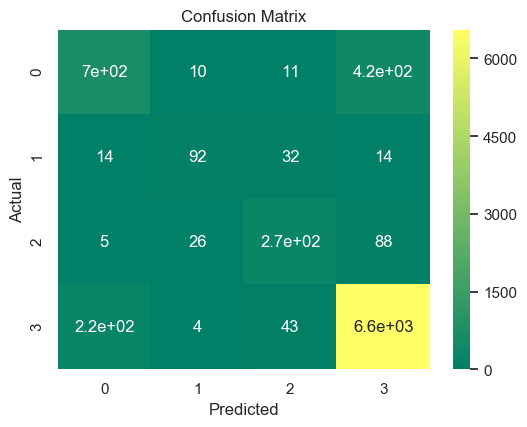

In [92]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(6,4.5)})
matplotlib.rcParams["figure.dpi"] = 100


cm = confusion_matrix(y_test,predicted)
sns.heatmap(cm, annot=True,cmap="summer"); #annot=True to annotate cells
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Using a decison tree to find the most important features as bagging clasifier doesn't have one.

model = DecisionTreeClassifier(criterion='gini',random_state = 100,max_depth=9,class_weight='balanced', min_samples_leaf=2)
model.fit(x_train, y_train)
giniPred = model.predict(x_test)

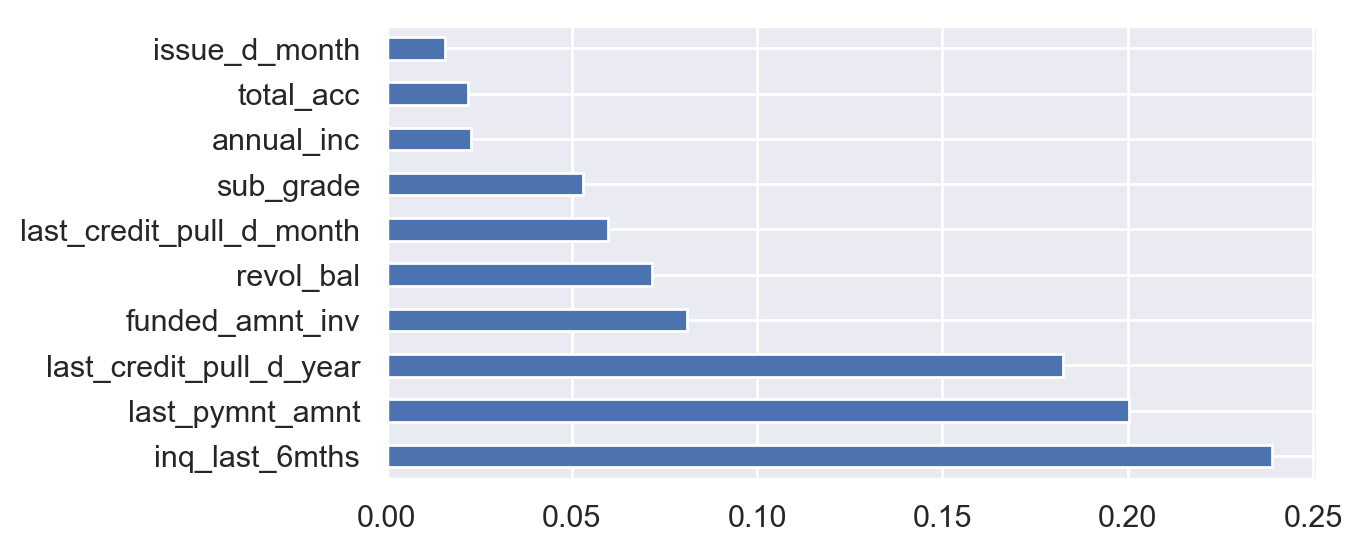

In [73]:
import matplotlib
sns.set(rc={'figure.figsize':(6,3)})
#sns.set_style('whitegrid')

matplotlib.rcParams["figure.dpi"] = 200
feat_importances = pd.Series(model.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig('feature_imp.png', dpi=100)
plt.show()